In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import re
from pathlib import Path

In [2]:
# Read in the data
_DATA_DIR = "./data"
_dataset_loan_columns = ["loan_amnt", 
                         "int_rate", 
                         "term", "grade", 
                         "sub_grade", 
                         "installment", 
                         "annual_inc", 
                         "revol_bal",
                         "revol_util",
                         "loan_status", 
                         "verification_status", 
                         "title", "purpose", 
                         "emp_title", 
                         "addr_state", 
                         "zip_code"]

dataset_loans = {}
for file_name in os.listdir(_DATA_DIR):
    if file_name.endswith(".csv"):
        full_file_path = _DATA_DIR + "/" + file_name
        print(full_file_path)
        loan_period = re.search(r'\d{4}Q[0-4]{1}', file_name).group(0)
        dataset_loans[loan_period] = pd.read_csv(full_file_path, usecols=_dataset_loan_columns)[_dataset_loan_columns]

./data/LoanStats_2016Q1.csv
./data/LoanStats_2016Q2.csv
./data/LoanStats_2016Q3.csv
./data/LoanStats_2016Q4.csv
./data/LoanStats_2017Q1.csv
./data/LoanStats_2017Q2.csv
./data/LoanStats_2017Q3.csv
./data/LoanStats_2017Q4.csv
./data/LoanStats_2018Q1.csv
./data/LoanStats_2018Q2.csv
./data/LoanStats_2018Q3.csv
./data/LoanStats_2018Q4.csv


In [3]:
# Plotting

from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase

from itertools import starmap

def plot_us_map(dict_data:dict, vmin:float=None, vmax:float=None, cmap=None, title:str="", save_directory:str="res/") -> None:
    plt.figure(figsize=(16,11))

    # https://stackoverflow.com/questions/40453163/plotting-points-on-a-map-of-the-united-states
    m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-62, urcrnrlat=51, projection='lcc', lat_1=32, lat_2=45, lon_0=-95)

    # https://infosys.ars.usda.gov/svn/code/weps1/trunk/weps.install/db/gis/st99_d00/
    # https://github.com/matplotlib/basemap/tree/master/examples
    m.readshapefile('map/st99_d00', name='states', drawbounds=True)
    
    if vmin is None:
        vmin = min(dict_data.values())
    if vmax is None:
        vmax = max(dict_data.values())
    
    all_states = set(state_info["NAME"] for state_info in m.states_info)
    data_states = set(dict_data.keys())
    
    state_set_difference = all_states - data_states - set(["Puerto Rico"])
    if len(state_set_difference) > 0 :
        print("Missing states in dict_data:", state_set_difference)
        print("Setting vMin to zero")
        vmin = 0
    
    print("vMin:", vmin)
    print("vMax:", vmax)
    print("Dataset Min:", min(dict_data.values()))
    print("Dataset Max:", max(dict_data.values()))
    
    ax = plt.gca()
    fig = plt.gcf()

    _NORMALIZE = Normalize(vmin=vmin, vmax=vmax)
    _COLORMAP = plt.cm.ScalarMappable(norm=_NORMALIZE, cmap=cmap)

    # Hawaii has 8 main islands but several tiny atolls that extend for many miles
    # This is the area cutoff between the 8 main islands and the tiny atolls
    _ATOLL_CUTOFF = 0.005        

    for state_info, seg in zip(m.states_info, m.states):
        state_name = state_info["NAME"]

        value = 0
        if state_name in dict_data:
            value = dict_data[state_name]
        color = _COLORMAP.to_rgba(value)
        if state_name in state_set_difference:
            color = (0, 0, 0, 0)

        # Offset Alaska and Hawaii to the lower-left corner
        # Offset Puerto Rico to the bottom-right corner
        if re.match("^Alaska", state_name):
            # Alaska is too big. Scale it down to 35% first, then transate it.
            seg = list(starmap(lambda x,y: (0.35*x + 980000, 0.35*y - 1300000), seg))
        elif re.match("^Hawaii", state_name) and float(state_info["AREA"]) > _ATOLL_CUTOFF:
            seg = list(starmap(lambda x,y: (x + 5100000, y - 1400000), seg))
        elif re.match("^Puerto Rico", state_name):
            seg = list(starmap(lambda x,y: (x - 1050000, y + 352738), seg))
            # Skipping, LendingClub is not available in Puerto Rico
            continue
        poly = Polygon(seg, facecolor=color, edgecolor="k", linewidth=.75)
        ax.add_patch(poly)

    plt.title(title)
    
    # Colorbar
    cax = fig.add_axes([.92, 0.125, 0.01, .75])
    colorbar = ColorbarBase(cax, cmap=cmap, norm=_NORMALIZE)
    
    plt.savefig(save_directory + title + ".png", bbox_inches="tight")
    plt.show()

In [4]:
# Load state name to state abbreviation mapping
df_abbv = pd.read_csv("population/state_abbv_to_state_name.csv")
abbv_to_state_name = df_abbv.set_index("Abbreviation").T.to_dict("records")[0]

df_abbv.head()

State Abbreviation
0     Alabama           AL
1      Alaska           AK
2     Arizona           AZ
3    Arkansas           AR
4  California           CA

In [5]:
# Load US Census population data
# https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-detail.html

_DATA_DIR = "./population/raw"

dataset_states = {}
for file_name in os.listdir(_DATA_DIR):
    if file_name.endswith(".csv"):
        full_file_path = _DATA_DIR + "/" + file_name
        print(full_file_path)
        df_state = pd.read_csv(full_file_path)
        
        # Remove first row containing summary
        df_state.drop(axis=0, index=0, inplace=True)
        # Remove last row containing Puerto Rico, LendingClub is not available in Puerto Rico
        df_state.drop(axis=0, index=len(df_state), inplace=True)
        
        population_year = re.search(r'\d{4}', file_name).group(0)
        dataset_states[population_year] = df_state

./population/raw/scprc-est2016-18+pop-res.csv
./population/raw/scprc-est2017-18+pop-res.csv
./population/raw/scprc-est2018-18+pop-res.csv


In [6]:
# We want POPEST18PLUS2016
dataset_states[list(dataset_states.keys())[0]].head()

SUMLEV REGION DIVISION  STATE        NAME  POPESTIMATE2016  \
1      40      3        6      1     Alabama          4863300   
2      40      4        9      2      Alaska           741894   
3      40      4        8      4     Arizona          6931071   
4      40      3        7      5    Arkansas          2988248   
5      40      4        9      6  California         39250017   

   POPEST18PLUS2016  PCNT_POPEST18PLUS  
1           3766477               77.4  
2            554567               74.8  
3           5299579               76.5  
4           2283195               76.4  
5          30157154               76.8

vMin: 442832
vMax: 30567090
Dataset Min: 446600
Dataset Max: 30157154


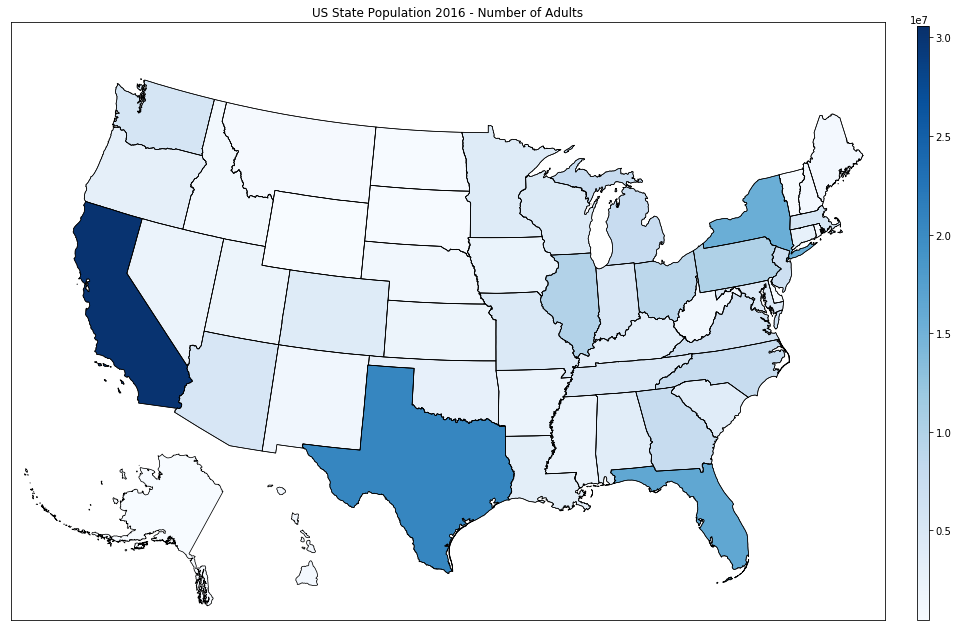

vMin: 442832
vMax: 30567090
Dataset Min: 442832
Dataset Max: 30476517


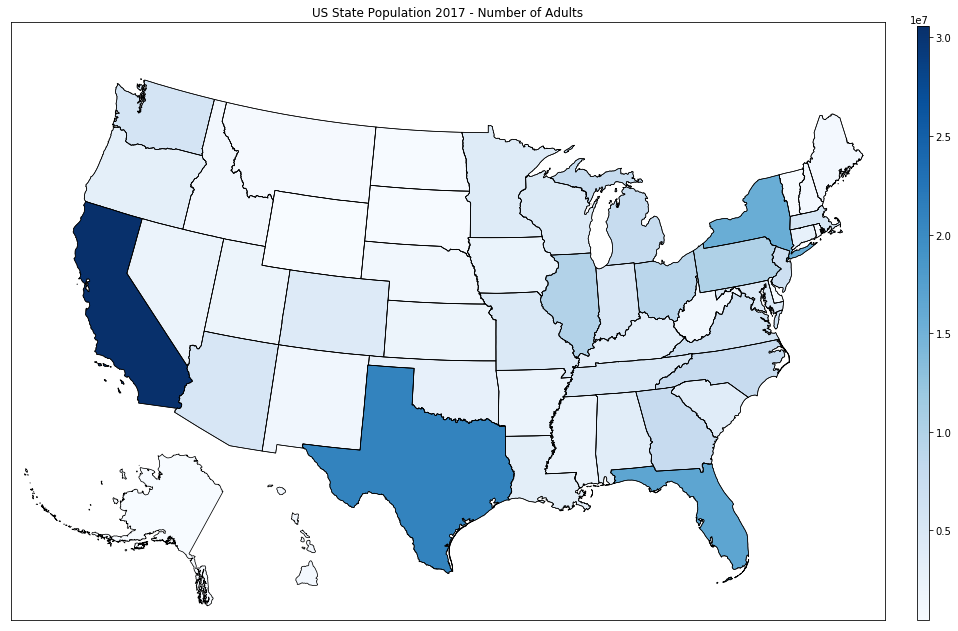

vMin: 442832
vMax: 30567090
Dataset Min: 442962
Dataset Max: 30567090


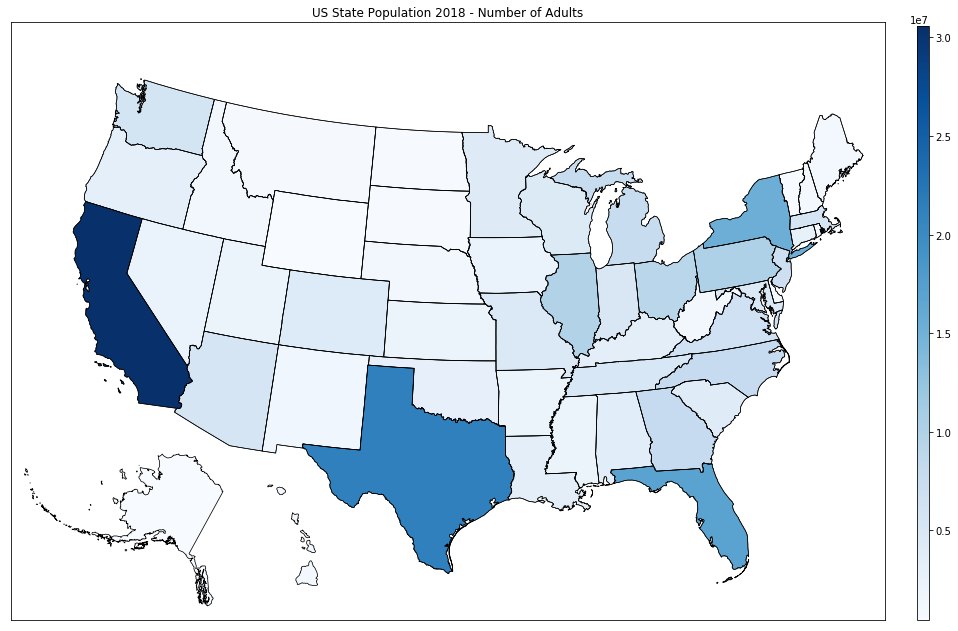

In [7]:
# Calculate min/max state population from 2016-2018
min_pop = float("inf")
max_pop = 0
for year, df_state in dataset_states.items():
    min_pop = min(min(df_state["POPEST18PLUS" + year]), min_pop)
    max_pop = max(max(df_state["POPEST18PLUS" + year]), max_pop)

# Plot population per state from 2016-2018
for year, df_state in dataset_states.items():
    state_population = {}
    for _, row in df_state.iterrows():
        state_name = row["NAME"]
        population = row["POPEST18PLUS" + year]
        state_population[state_name] = population
    plot_us_map(state_population, vmin=min_pop, vmax=max_pop, cmap=plt.cm.Blues, title=f"US State Population {year} - Number of Adults", save_directory="res/Time Series - Population/")

In [8]:
# Gets the index of labels in the group
# Returns pandas.core.indexes.numeric.Int64Index
def get_indexes(groups:dict, labels:list):
    indexes = None
    for label in labels:
        if label in groups.groups:
            if indexes is None:
                indexes = groups.groups[label]
            else:
                indexes = indexes.union(groups.groups[label])
    return indexes

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 278257700
Dataset Min: 694000
Dataset Max: 43605200


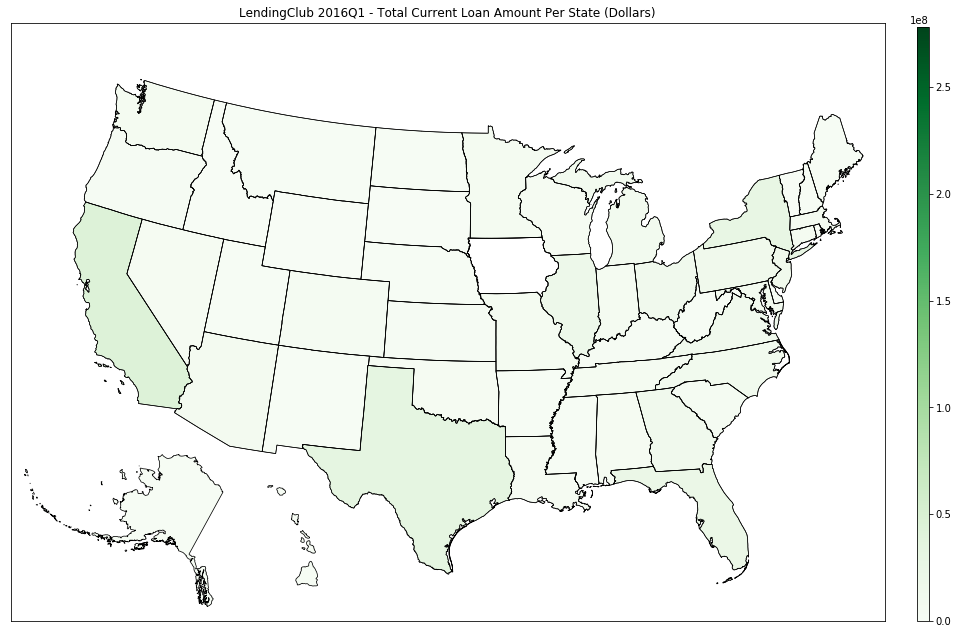

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 278257700
Dataset Min: 962875
Dataset Max: 62284025


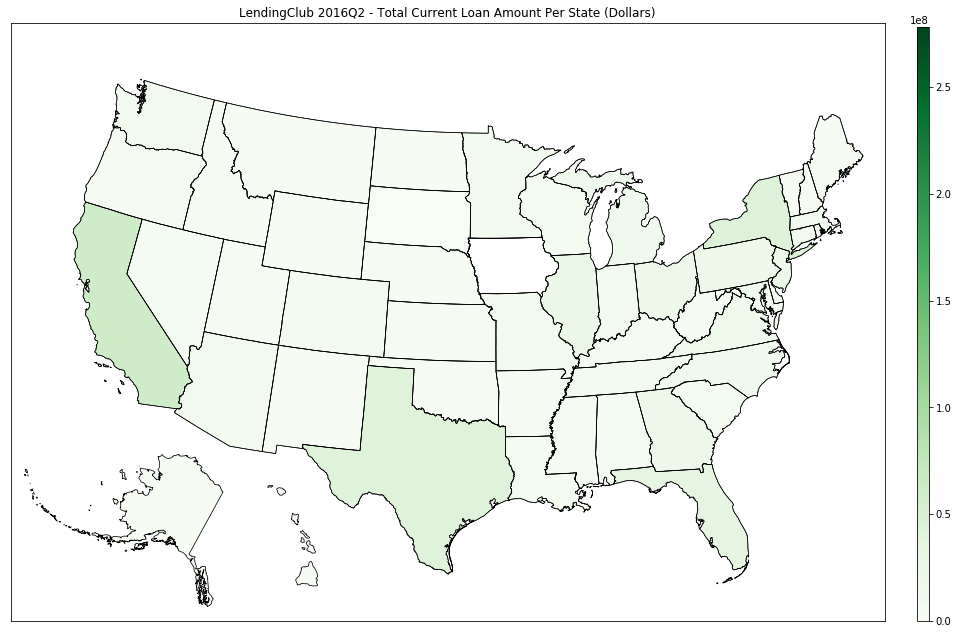

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 278257700
Dataset Min: 23000
Dataset Max: 65597125


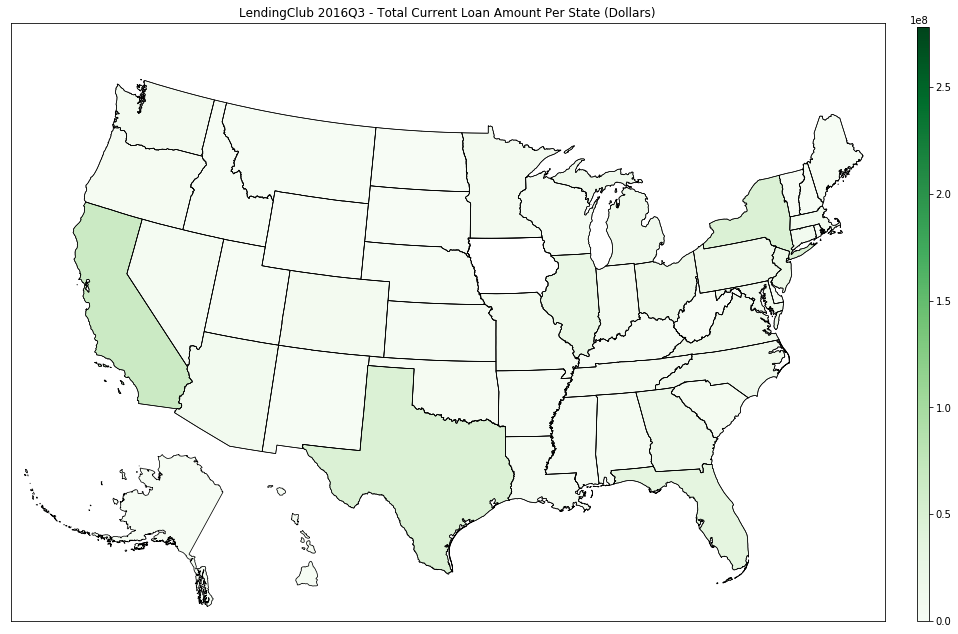

Missing states in dict_data: {'Iowa', 'West Virginia'}
Setting vMin to zero
vMin: 0
vMax: 278257700
Dataset Min: 1133850
Dataset Max: 78057350


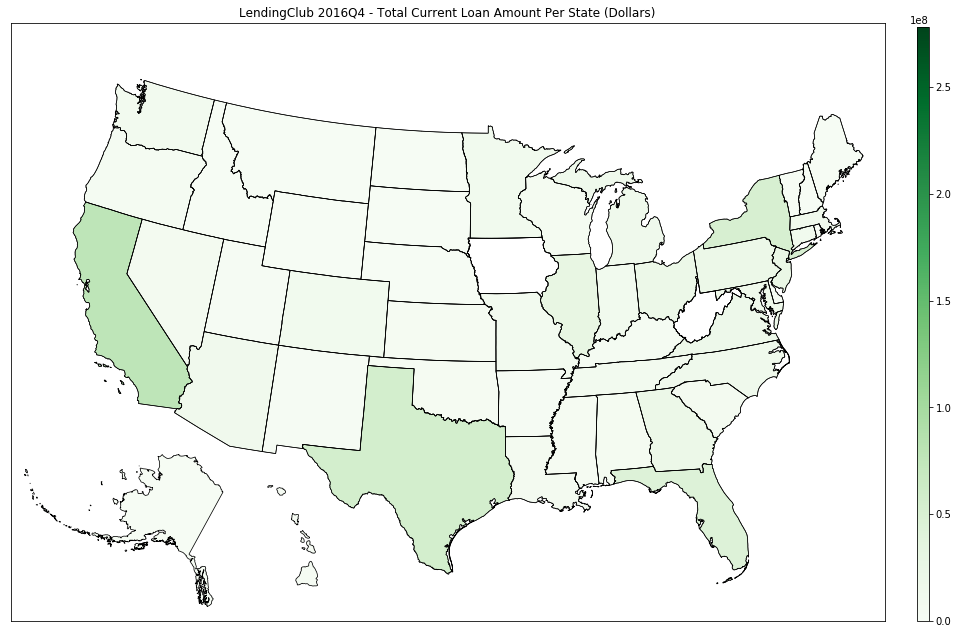

Missing states in dict_data: {'Iowa', 'West Virginia'}
Setting vMin to zero
vMin: 0
vMax: 278257700
Dataset Min: 1390100
Dataset Max: 95700250


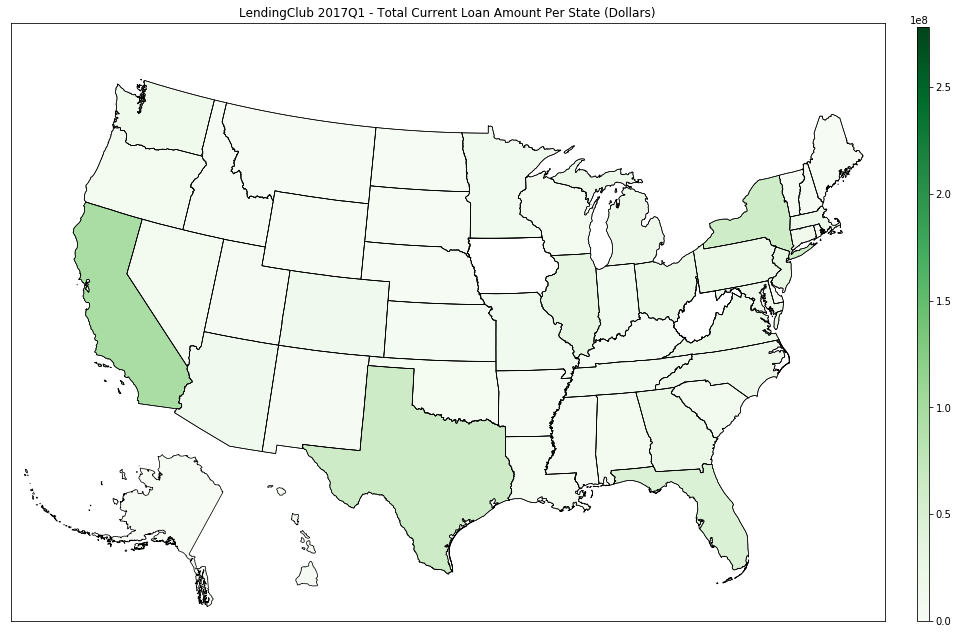

Missing states in dict_data: {'Iowa', 'West Virginia'}
Setting vMin to zero
vMin: 0
vMax: 278257700
Dataset Min: 1360875
Dataset Max: 109417075


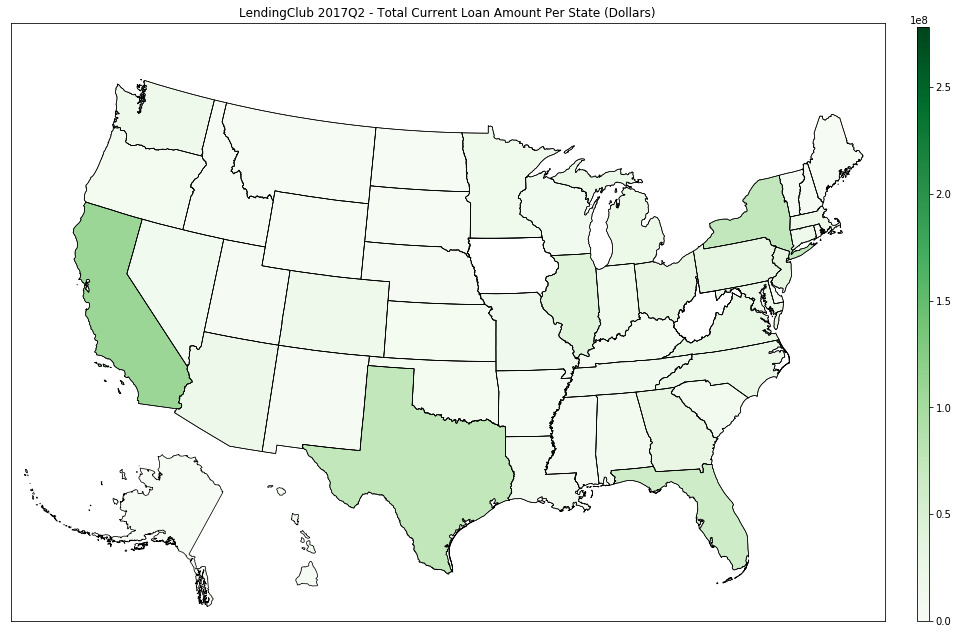

Missing states in dict_data: {'Iowa', 'West Virginia'}
Setting vMin to zero
vMin: 0
vMax: 278257700
Dataset Min: 1894950
Dataset Max: 144236375


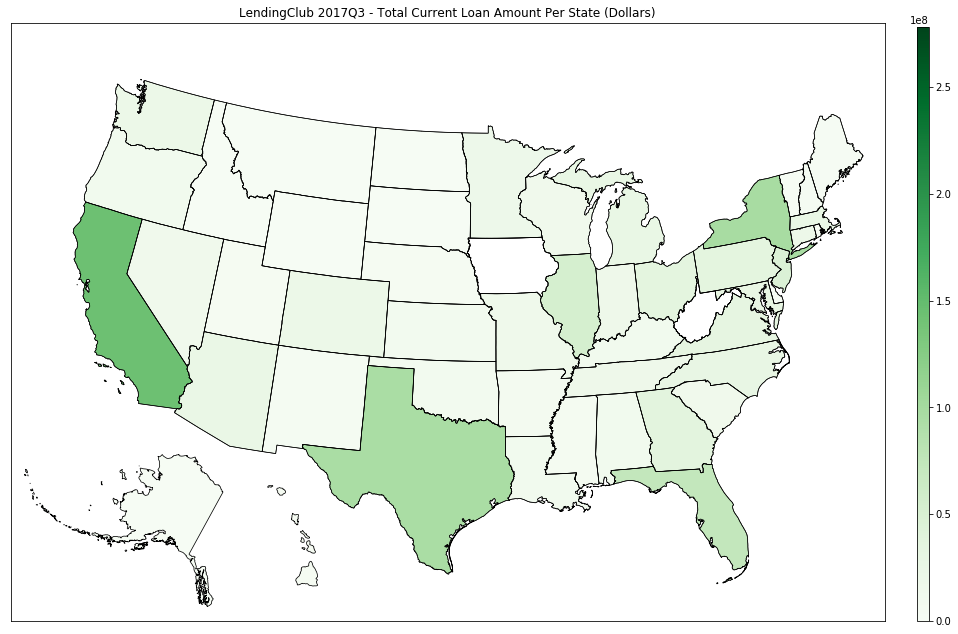

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 278257700
Dataset Min: 2707200
Dataset Max: 190024450


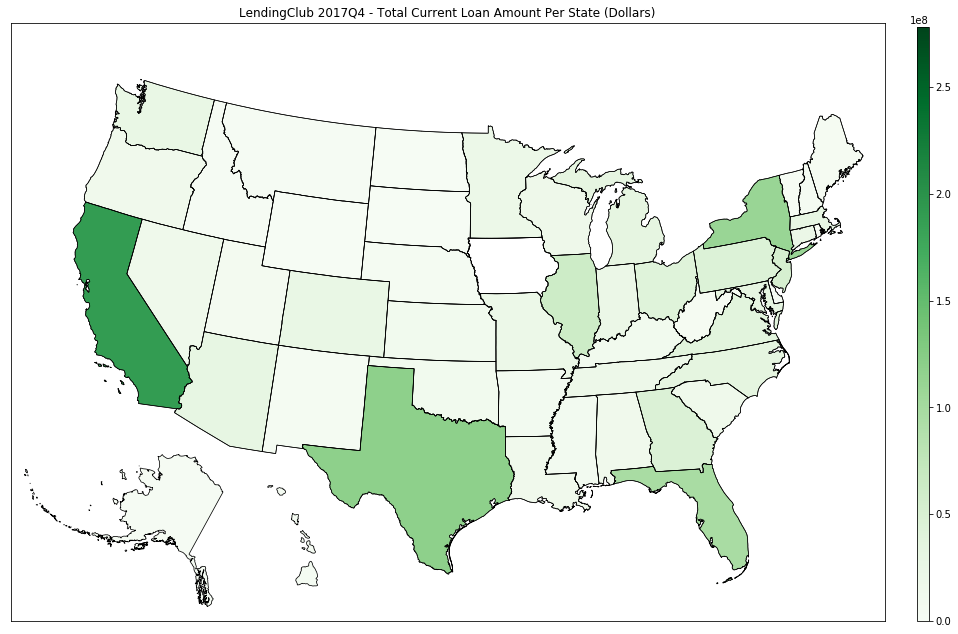

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 278257700
Dataset Min: 2728325
Dataset Max: 196930350


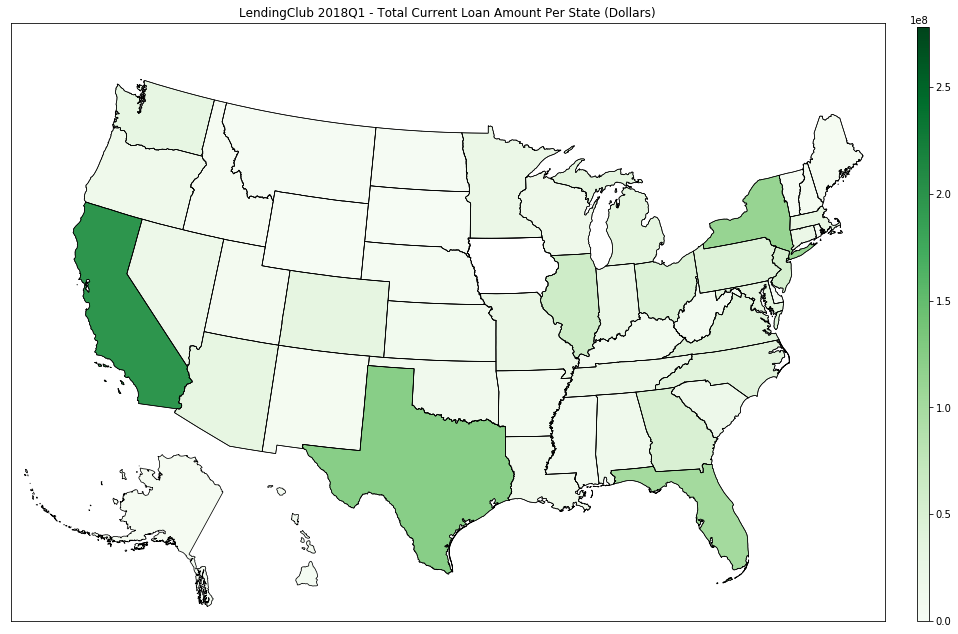

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 278257700
Dataset Min: 2957925
Dataset Max: 248013100


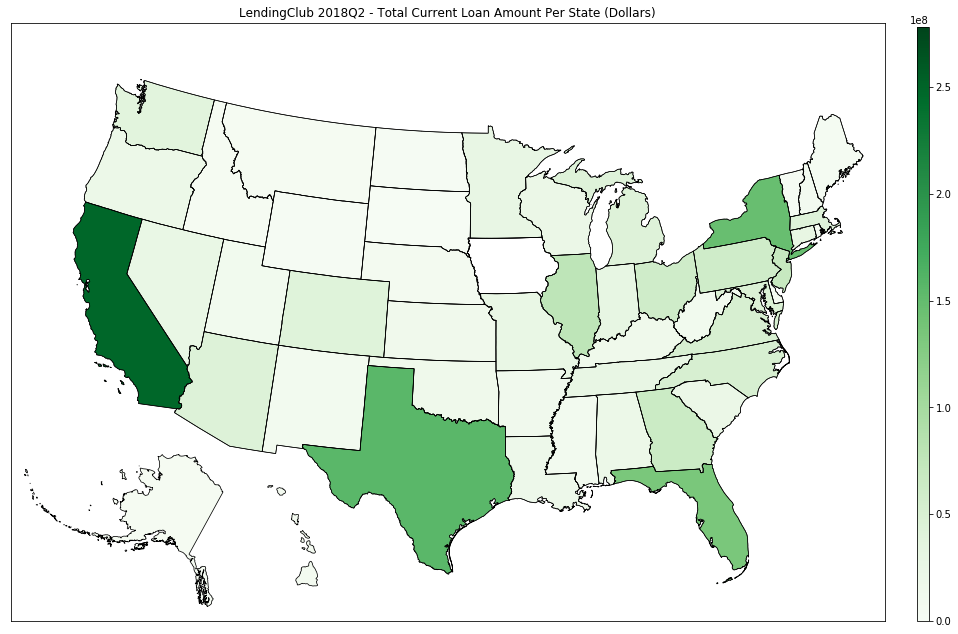

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 278257700
Dataset Min: 3538375
Dataset Max: 269297525


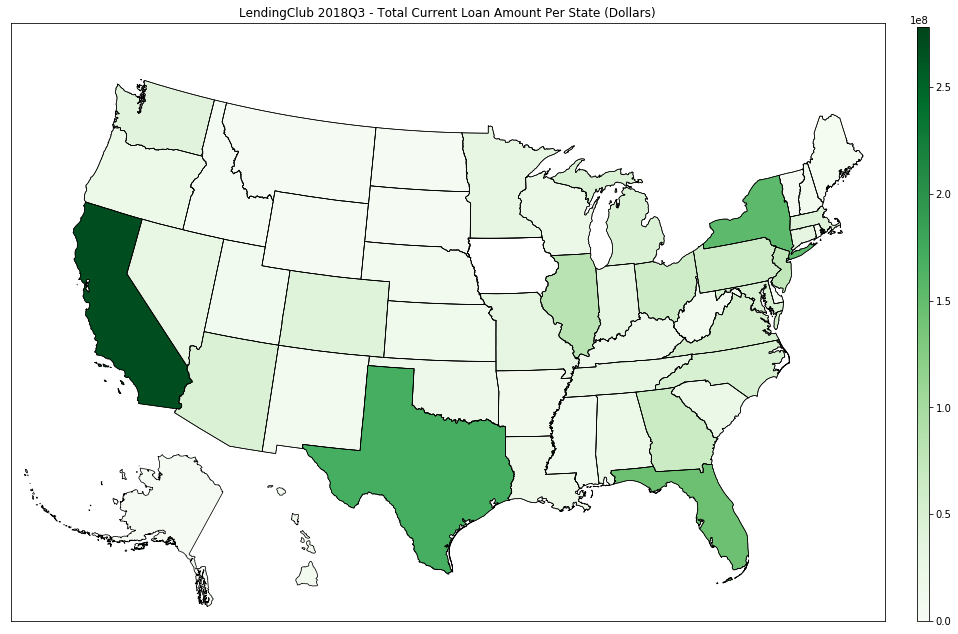

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 278257700
Dataset Min: 4049875
Dataset Max: 278257700


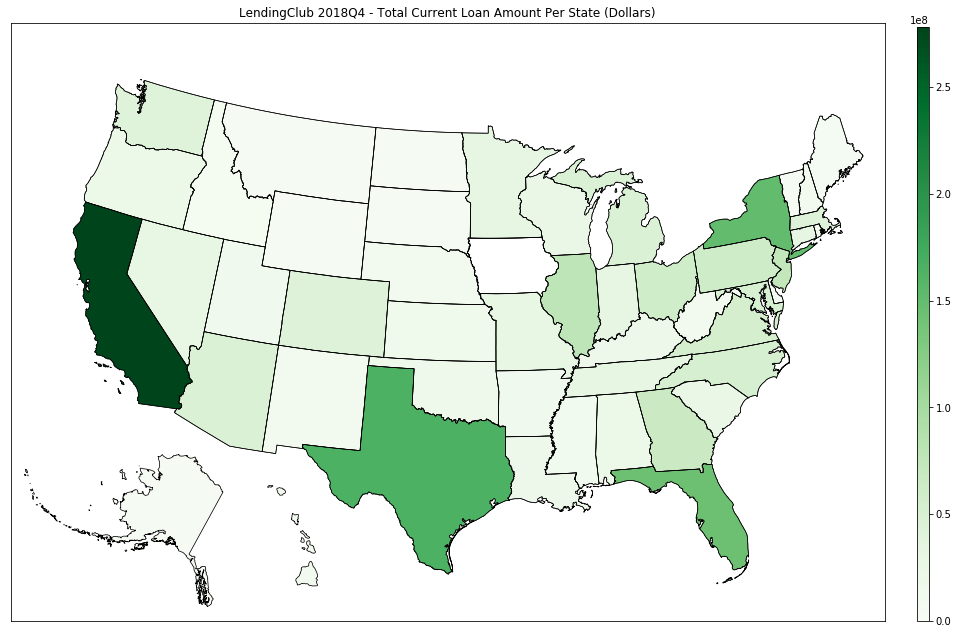

In [9]:
# Calculate min/max of the total current loan amount per state for all states
min_loan_amnt = float("inf")
max_loan_amnt = 0
for loan_period, df_state in dataset_loans.items():
    loan_current_by_state = {}
    
    loan_status_groups = df_state.groupby("loan_status", sort=False)
    loan_status_indexes = get_indexes(loan_status_groups, labels=["Current"])
    
    for state_abbv, row_idx in df_state.loc[loan_status_indexes].groupby("addr_state").groups.items():
        state_name = abbv_to_state_name[state_abbv]
        loan_current_by_state[state_name] = sum(df_state.loc[row_idx]["loan_amnt"])
    min_loan_amnt = min(min(loan_current_by_state.values()), min_loan_amnt)
    max_loan_amnt = max(max(loan_current_by_state.values()), max_loan_amnt)

# Plot the total current loan amount per state
for loan_period, df_state in dataset_loans.items():
    loan_current_by_state = {}
    
    loan_status_groups = df_state.groupby("loan_status", sort=False)
    loan_status_indexes = get_indexes(loan_status_groups, ["Current"])
    
    for state_abbv, row_idx in df_state.loc[loan_status_indexes].groupby("addr_state").groups.items():
        state_name = abbv_to_state_name[state_abbv]
        loan_current_by_state[state_name] = sum(df_state.loc[row_idx]["loan_amnt"])
    plot_us_map(loan_current_by_state, vmin=min_loan_amnt, vmax=max_loan_amnt, cmap=plt.cm.Greens, title=f"LendingClub {loan_period} - Total Current Loan Amount Per State (Dollars)", save_directory="res/Time Series - Total Current Loan Amount Per State/")

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 8665225
Dataset Min: 10000
Dataset Max: 2476300


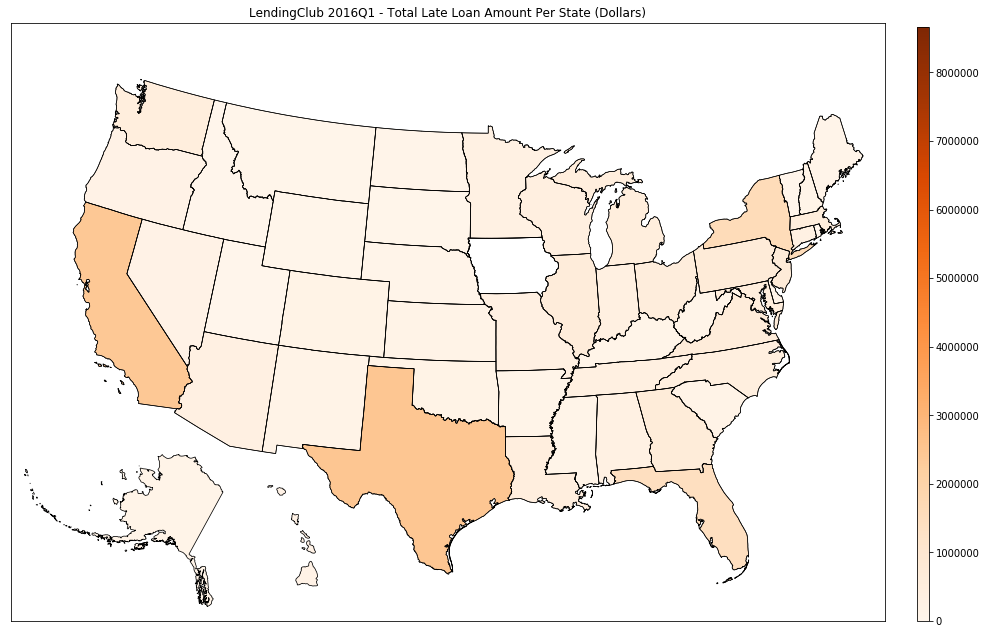

Missing states in dict_data: {'District of Columbia', 'Delaware', 'North Dakota', 'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 8665225
Dataset Min: 10125
Dataset Max: 2482550


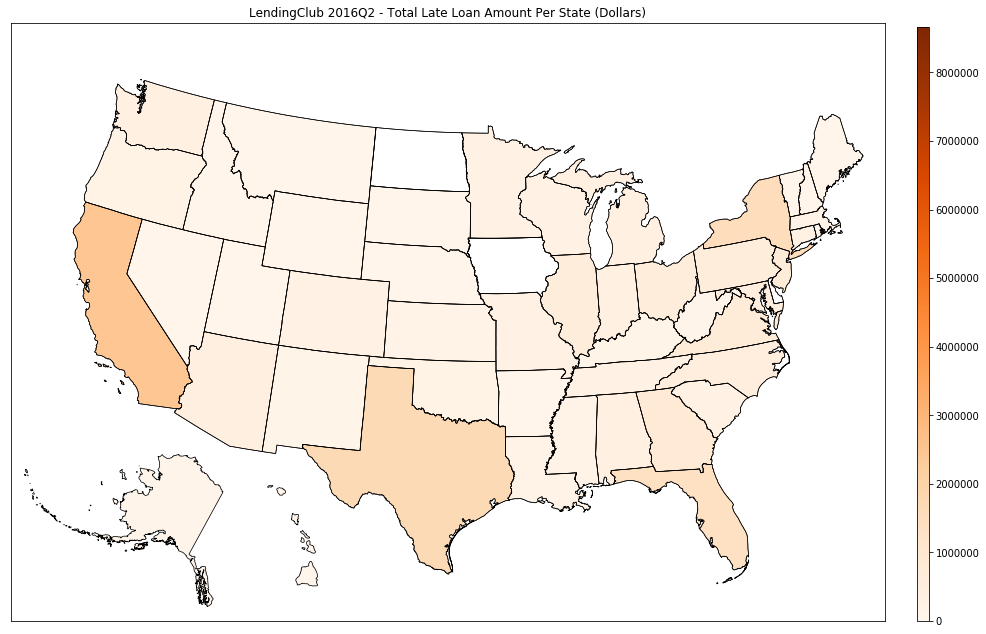

Missing states in dict_data: {'Iowa', 'West Virginia', 'Maine', 'South Dakota'}
Setting vMin to zero
vMin: 0
vMax: 8665225
Dataset Min: 8000
Dataset Max: 2627000


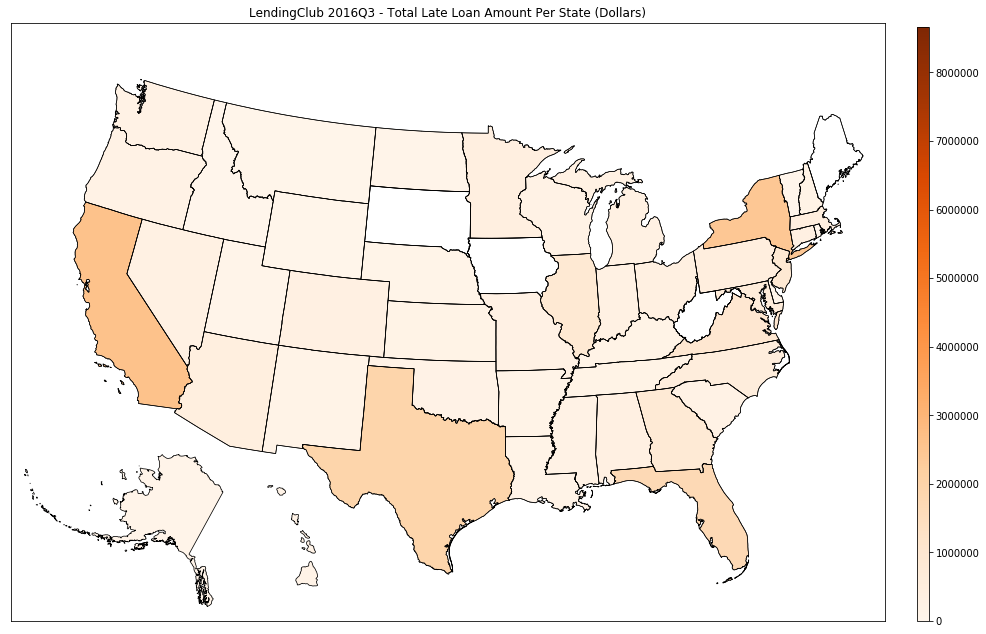

Missing states in dict_data: {'Iowa', 'West Virginia'}
Setting vMin to zero
vMin: 0
vMax: 8665225
Dataset Min: 5000
Dataset Max: 3938475


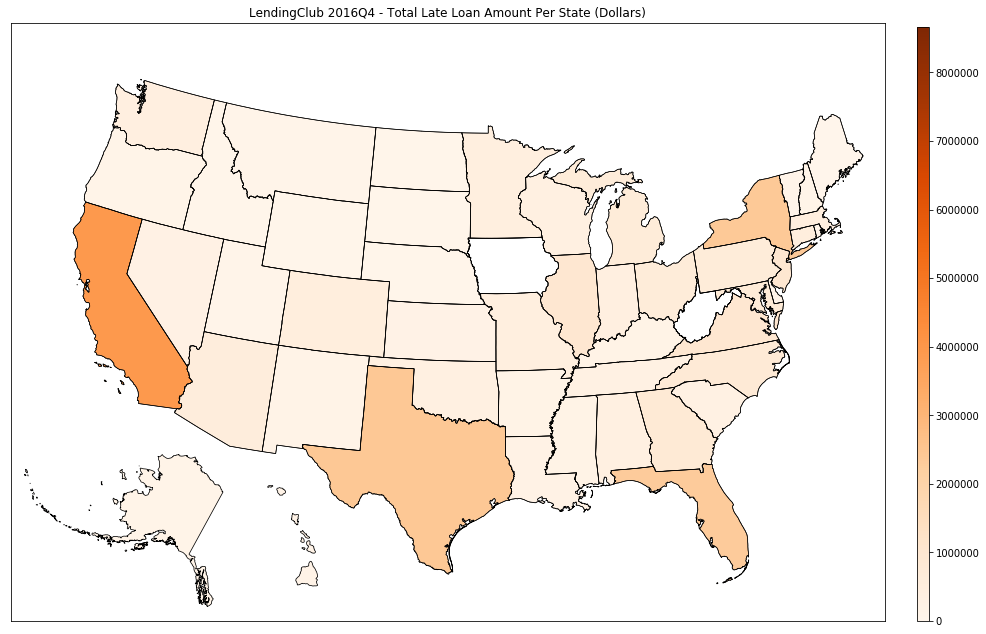

Missing states in dict_data: {'Iowa', 'West Virginia'}
Setting vMin to zero
vMin: 0
vMax: 8665225
Dataset Min: 31000
Dataset Max: 4155300


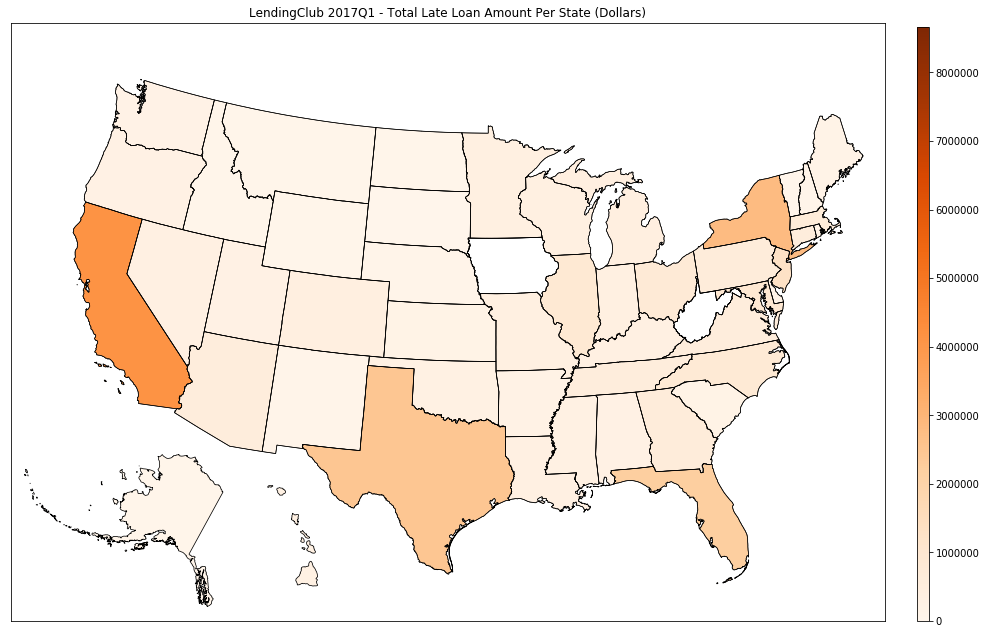

Missing states in dict_data: {'Iowa', 'West Virginia'}
Setting vMin to zero
vMin: 0
vMax: 8665225
Dataset Min: 44950
Dataset Max: 4605900


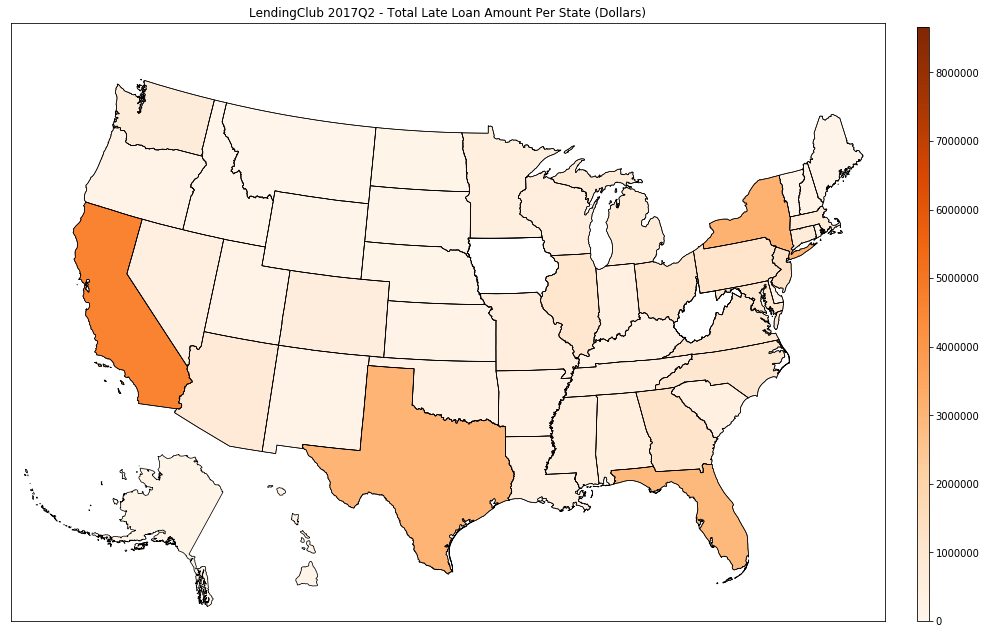

Missing states in dict_data: {'Iowa', 'West Virginia'}
Setting vMin to zero
vMin: 0
vMax: 8665225
Dataset Min: 35300
Dataset Max: 6396325


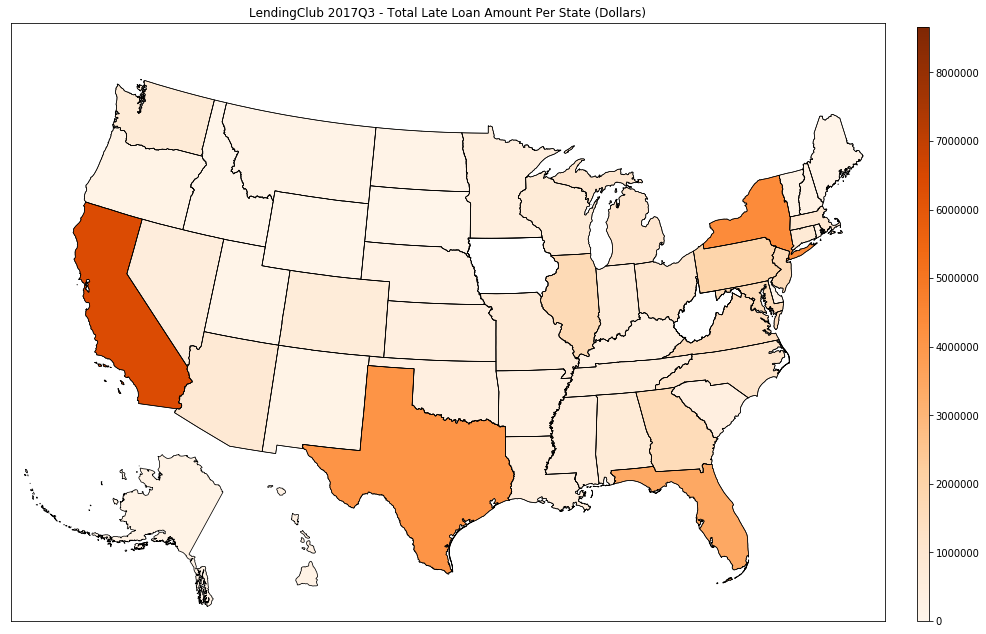

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 8665225
Dataset Min: 51500
Dataset Max: 8665225


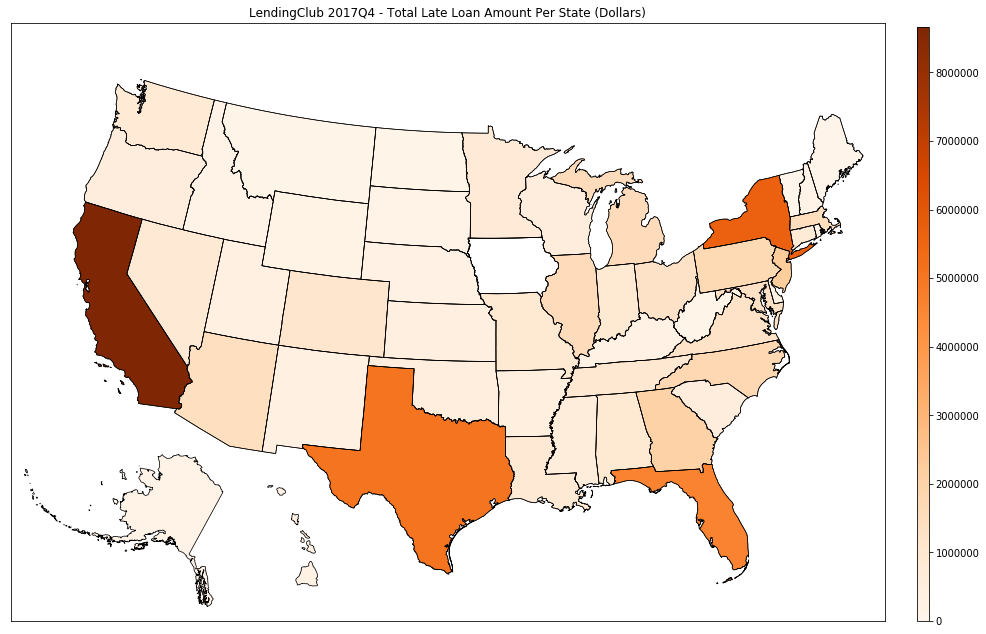

Missing states in dict_data: {'Iowa', 'Wyoming'}
Setting vMin to zero
vMin: 0
vMax: 8665225
Dataset Min: 22400
Dataset Max: 6605050


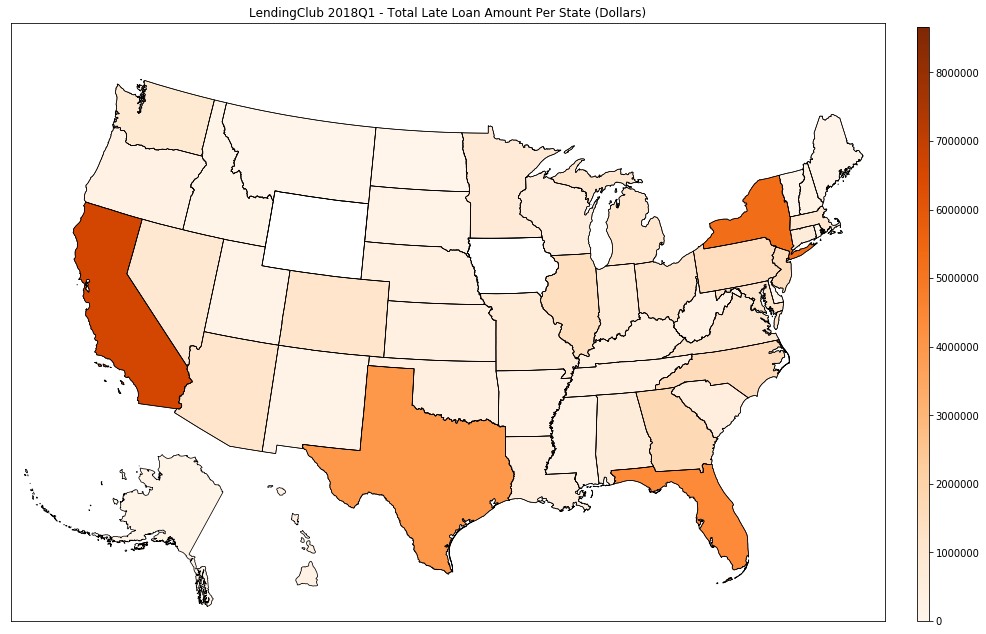

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 8665225
Dataset Min: 43525
Dataset Max: 8219200


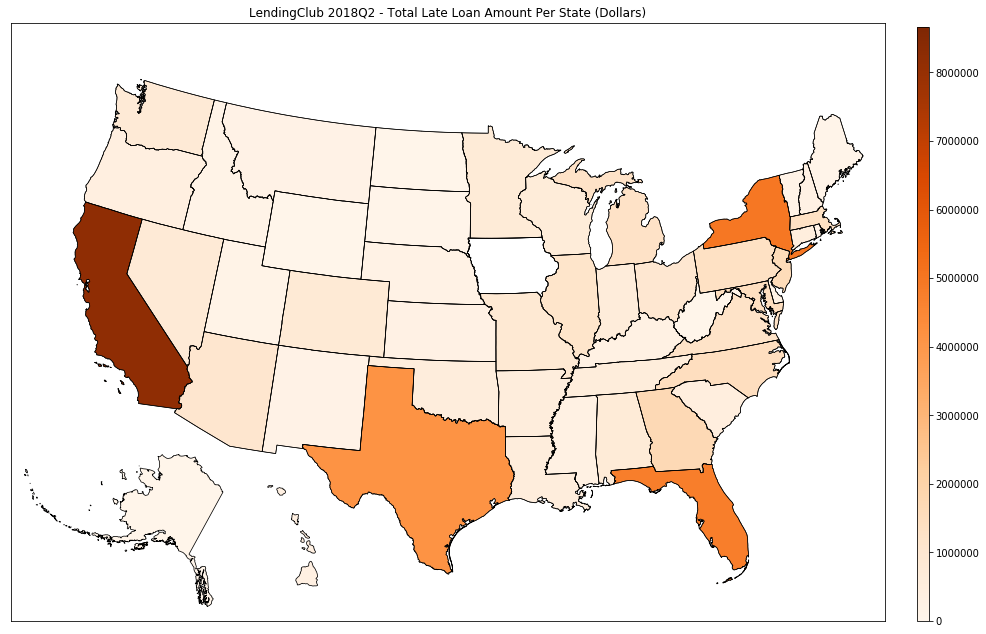

Missing states in dict_data: {'Iowa', 'Maine'}
Setting vMin to zero
vMin: 0
vMax: 8665225
Dataset Min: 4550
Dataset Max: 3146775


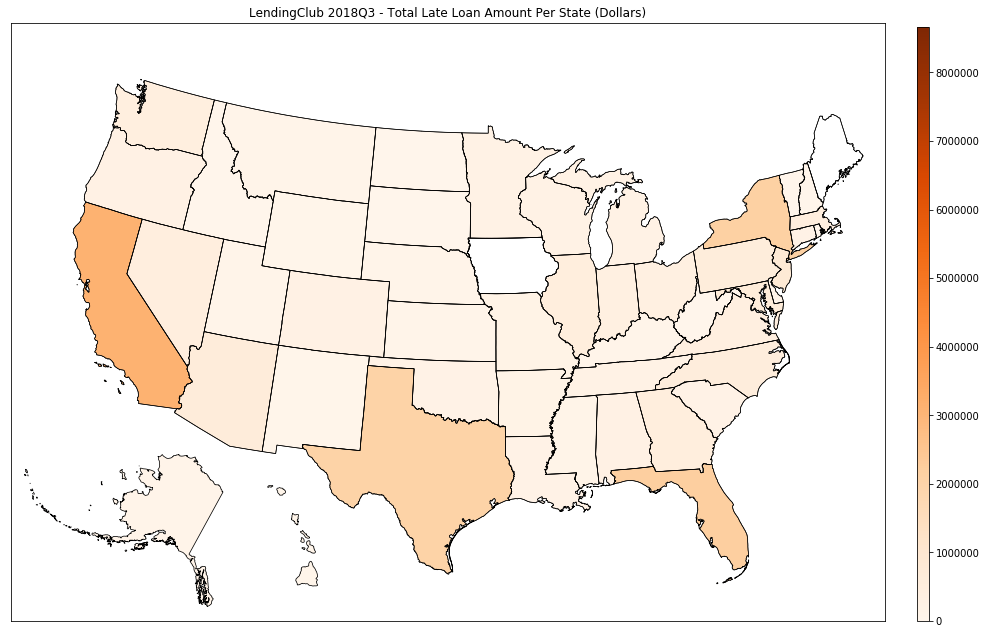

Missing states in dict_data: {'Iowa', 'Maine', 'South Dakota'}
Setting vMin to zero
vMin: 0
vMax: 8665225
Dataset Min: 7000
Dataset Max: 3839100


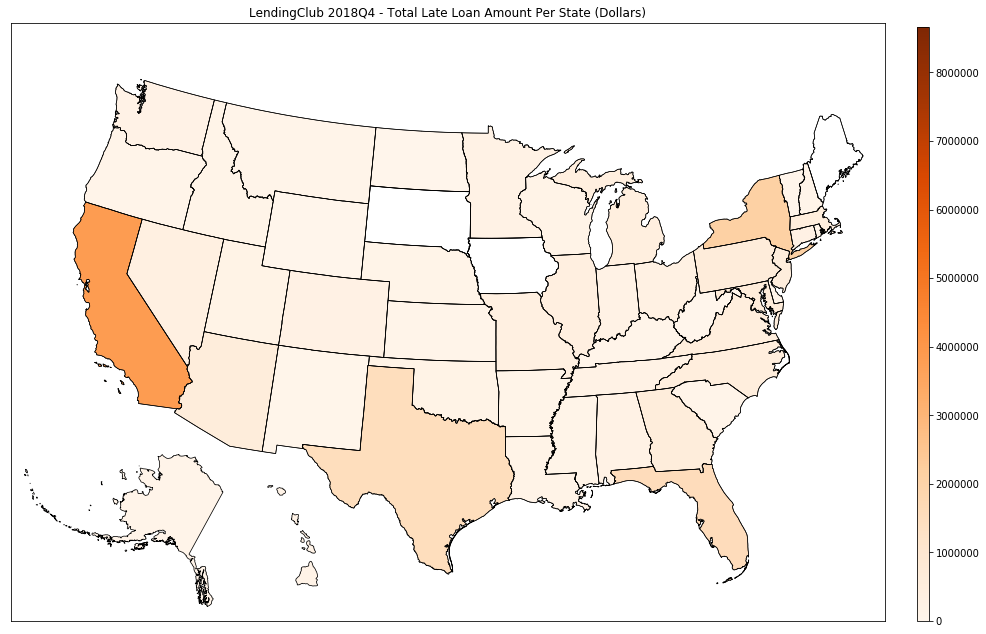

In [10]:
# Calculate min/max of the total late loan amount per state for all states
min_loan_amnt = float("inf")
max_loan_amnt = 0
for loan_period, df_state in dataset_loans.items():
    loan_current_by_state = {}
    
    loan_status_groups = df_state.groupby("loan_status", sort=False)
    loan_status_indexes = get_indexes(loan_status_groups, ["Late (16-30 days)", "Late (31-120 days)"])
    
    for state_abbv, row_idx in df_state.loc[loan_status_indexes].groupby("addr_state").groups.items():
        state_name = abbv_to_state_name[state_abbv]
        loan_current_by_state[state_name] = sum(df_state.loc[row_idx]["loan_amnt"])
    min_loan_amnt = min(min(loan_current_by_state.values()), min_loan_amnt)
    max_loan_amnt = max(max(loan_current_by_state.values()), max_loan_amnt)

# Plot the total late loan amount per state
for loan_period, df_state in dataset_loans.items():
    loan_current_by_state = {}
    
    loan_status_groups = df_state.groupby("loan_status", sort=False)
    loan_status_indexes = get_indexes(loan_status_groups, ["Late (16-30 days)", "Late (31-120 days)"])
    
    for state_abbv, row_idx in df_state.loc[loan_status_indexes].groupby("addr_state").groups.items():
        state_name = abbv_to_state_name[state_abbv]
        loan_current_by_state[state_name] = sum(df_state.loc[row_idx]["loan_amnt"])
    plot_us_map(loan_current_by_state, vmin=min_loan_amnt, vmax=max_loan_amnt, cmap=plt.cm.Oranges, title=f"LendingClub {loan_period} - Total Late Loan Amount Per State (Dollars)", save_directory="res/Time Series - Total Late Loan Amount Per State/")

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 52676725
Dataset Min: 401750
Dataset Max: 52676725


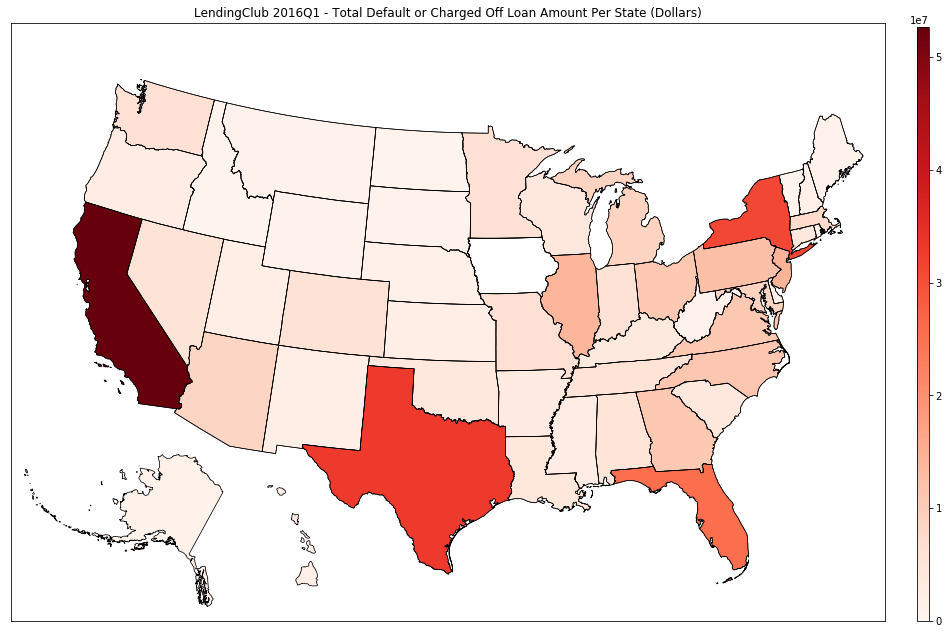

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 52676725
Dataset Min: 289850
Dataset Max: 32644100


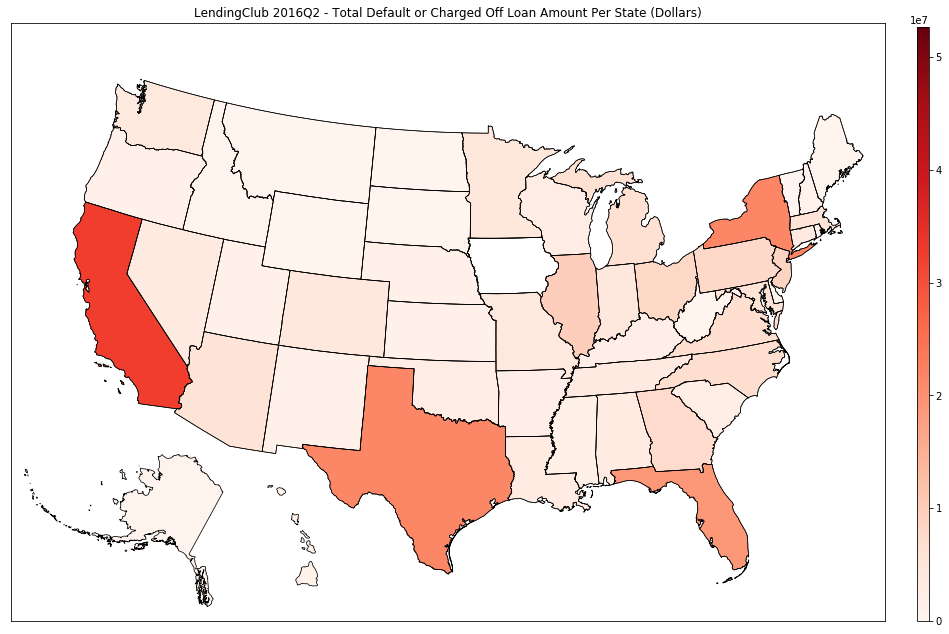

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 52676725
Dataset Min: 12000
Dataset Max: 36256200


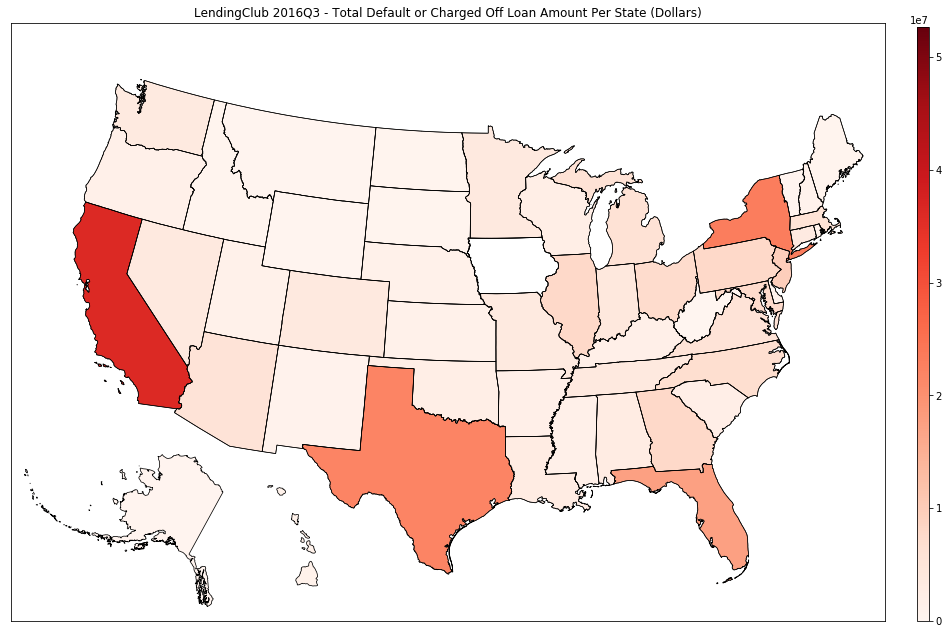

Missing states in dict_data: {'Iowa', 'West Virginia'}
Setting vMin to zero
vMin: 0
vMax: 52676725
Dataset Min: 245550
Dataset Max: 29928900


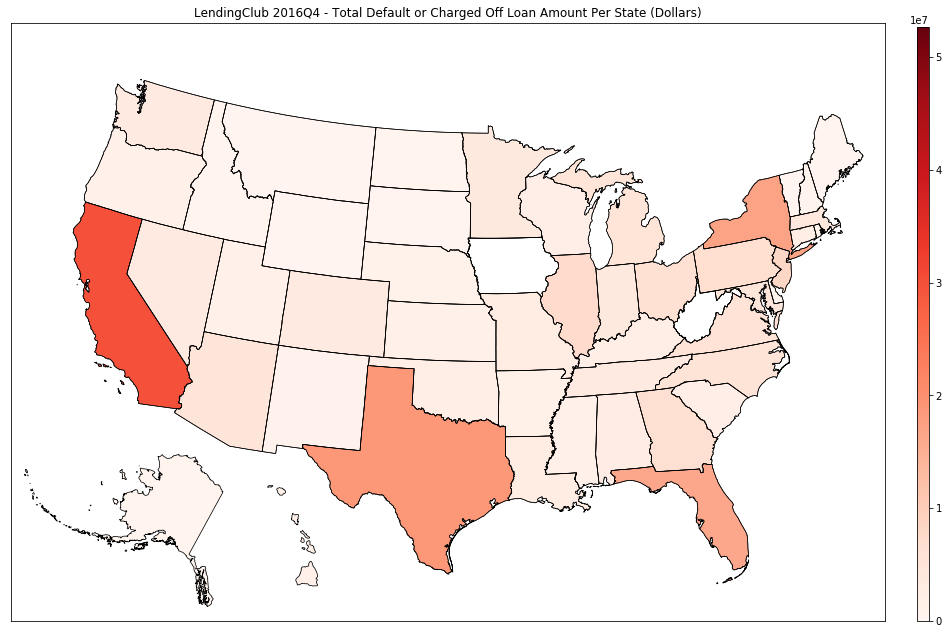

Missing states in dict_data: {'Iowa', 'West Virginia'}
Setting vMin to zero
vMin: 0
vMax: 52676725
Dataset Min: 210875
Dataset Max: 26262875


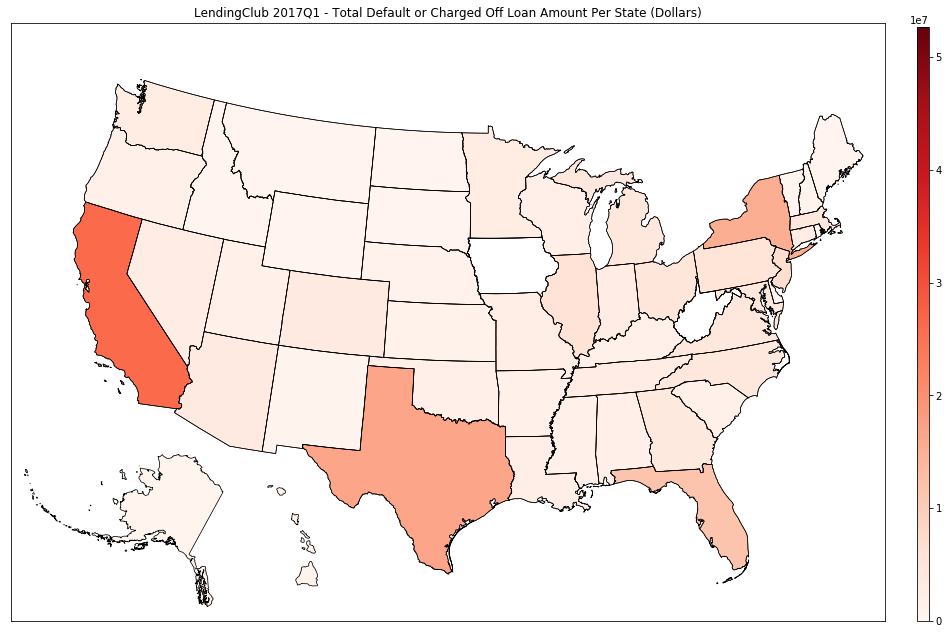

Missing states in dict_data: {'Iowa', 'West Virginia'}
Setting vMin to zero
vMin: 0
vMax: 52676725
Dataset Min: 144000
Dataset Max: 23359700


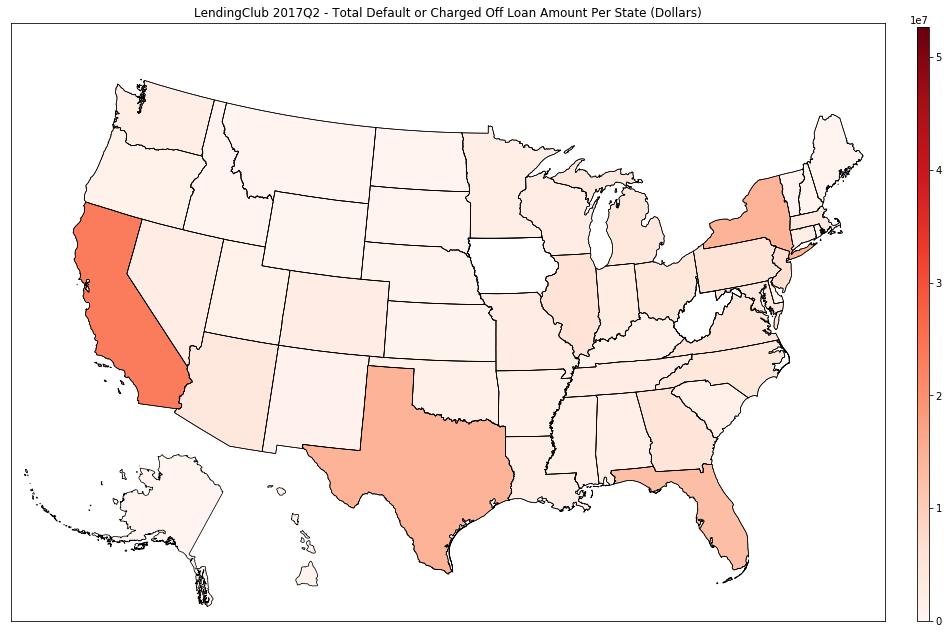

Missing states in dict_data: {'Iowa', 'West Virginia'}
Setting vMin to zero
vMin: 0
vMax: 52676725
Dataset Min: 130600
Dataset Max: 23571350


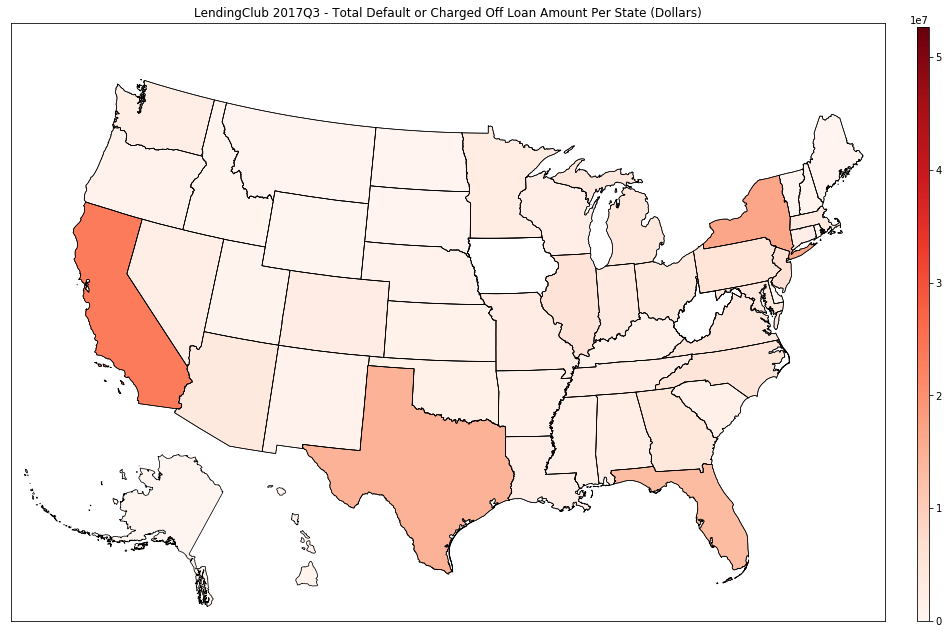

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 52676725
Dataset Min: 104000
Dataset Max: 13990750


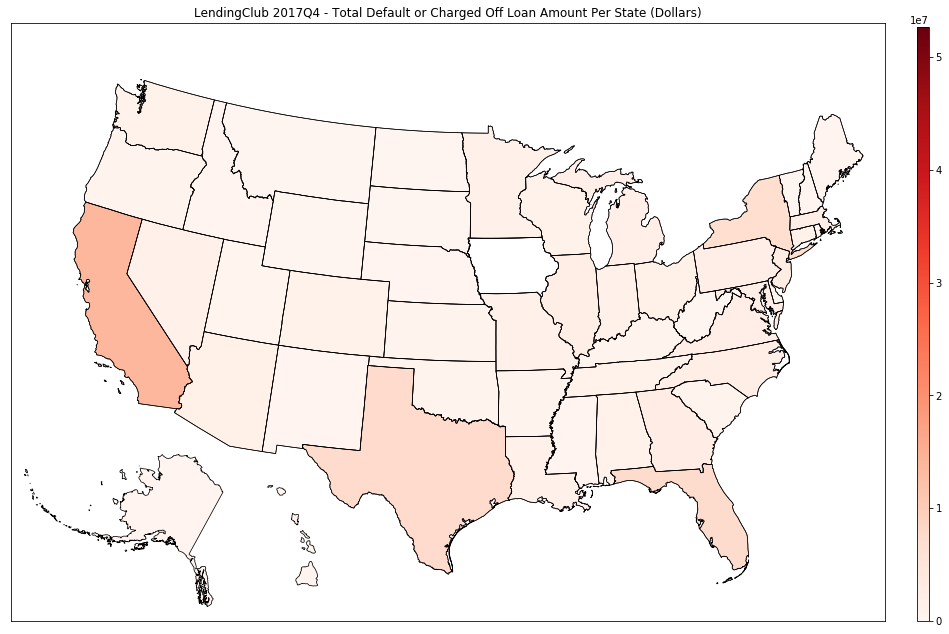

Missing states in dict_data: {'Iowa'}
Setting vMin to zero
vMin: 0
vMax: 52676725
Dataset Min: 5000
Dataset Max: 6992150


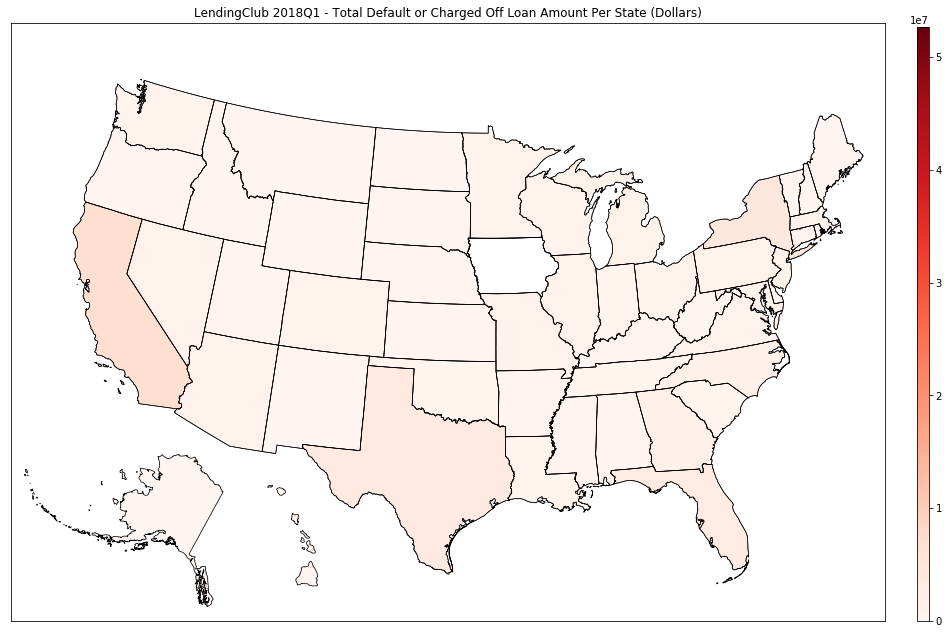

Missing states in dict_data: {'Iowa', 'District of Columbia', 'Wyoming'}
Setting vMin to zero
vMin: 0
vMax: 52676725
Dataset Min: 9000
Dataset Max: 3675100


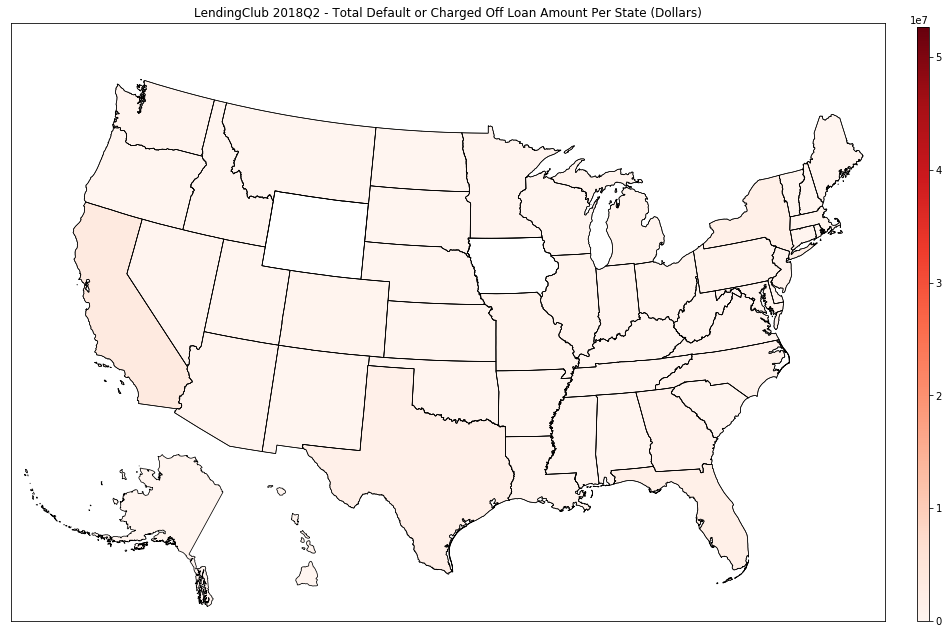

Missing states in dict_data: {'Nevada', 'South Carolina', 'Vermont', 'District of Columbia', 'Wyoming', 'Oregon', 'Alaska', 'Iowa', 'Oklahoma', 'Idaho', 'Montana', 'Hawaii', 'Maine', 'South Dakota', 'Nebraska', 'Rhode Island', 'Arkansas', 'West Virginia'}
Setting vMin to zero
vMin: 0
vMax: 52676725
Dataset Min: 1000
Dataset Max: 265050


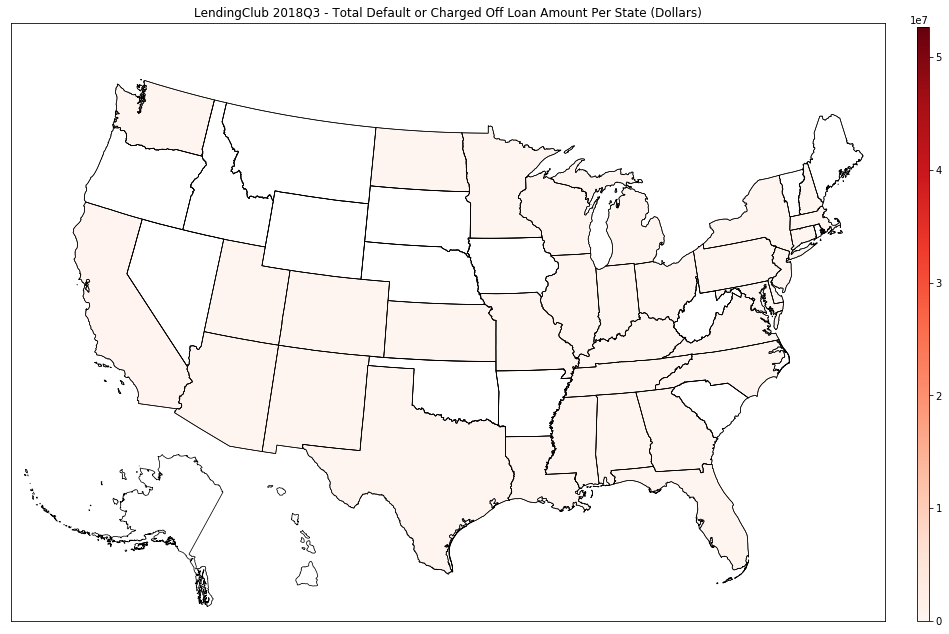

Missing states in dict_data: {'Vermont', 'Wyoming', 'New Mexico', 'Kansas', 'Oregon', 'Alaska', 'Iowa', 'Kentucky', 'New Hampshire', 'Idaho', 'Montana', 'Hawaii', 'South Dakota', 'Nebraska', 'Rhode Island', 'West Virginia'}
Setting vMin to zero
vMin: 0
vMax: 52676725
Dataset Min: 1600
Dataset Max: 291500


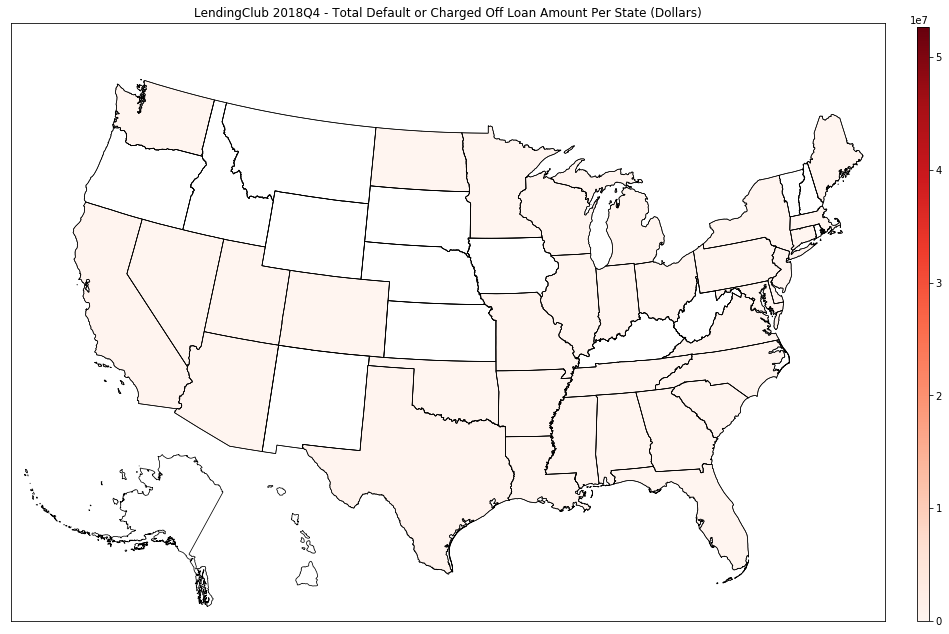

In [11]:
# Calculate min/max of the total default loan amount per state for all states
min_loan_amnt = float("inf")
max_loan_amnt = 0
for loan_period, df_state in dataset_loans.items():
    loan_current_by_state = {}
    
    loan_status_groups = df_state.groupby("loan_status", sort=False)
    loan_status_indexes = get_indexes(loan_status_groups, ["Default", "Charged Off"])
    
    for state_abbv, row_idx in df_state.loc[loan_status_indexes].groupby("addr_state").groups.items():
        state_name = abbv_to_state_name[state_abbv]
        loan_current_by_state[state_name] = sum(df_state.loc[row_idx]["loan_amnt"])
    min_loan_amnt = min(min(loan_current_by_state.values()), min_loan_amnt)
    max_loan_amnt = max(max(loan_current_by_state.values()), max_loan_amnt)

# Plot the total default loan amount per state
for loan_period, df_state in dataset_loans.items():
    loan_current_by_state = {}
    
    loan_status_groups = df_state.groupby("loan_status", sort=False)
    loan_status_indexes = get_indexes(loan_status_groups, ["Default", "Charged Off"])
    
    for state_abbv, row_idx in df_state.loc[loan_status_indexes].groupby("addr_state").groups.items():
        state_name = abbv_to_state_name[state_abbv]
        loan_current_by_state[state_name] = sum(df_state.loc[row_idx]["loan_amnt"])
    plot_us_map(loan_current_by_state, vmin=min_loan_amnt, vmax=max_loan_amnt, cmap=plt.cm.Reds, title=f"LendingClub {loan_period} - Total Default or Charged Off Loan Amount Per State (Dollars)", save_directory="res/Time Series - Total Default Or Charged Off Loan Amount Per State/")